In [8]:
from utils_az import FishEyeImage, rot
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.optimize import minimize, curve_fit
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, angular_separation, position_angle, offset_by, ICRS
from PIL import Image
from photutils.aperture import CircularAperture


In [9]:
file = 'img-z'

zhangbei = EarthLocation(lon=115*u.deg+14*u.arcsec,lat=41*u.deg+13*u.arcmin+53*u.arcsec,height = 1466)
dunhuang  = EarthLocation(lon=94.322799*u.deg,lat=40.359581*u.deg,height = 1100)
pic = FishEyeImage( file+'.CR3',loc = zhangbei)

solution = pic.solve(solve_size=100)
_,_=pic.detect_stars_az()

{'RA': 132.12251463740864, 'Dec': -23.358488086745684, 'Roll': 350.7811165435673, 'FOV': 23.6655989742987, 'distortion': -0.006548529564503327, 'RMSE': 31.627664904848633, 'Matches': 26, 'Prob': 1.0193527449677233e-48, 'epoch_equinox': 2000, 'epoch_proper_motion': 2023.0, 'T_solve': 3.663300070911646, 'T_extract': 47.38639993593097}


In [10]:
pic.first_match(bin_size=5000, max_sep=40)


(array([1396,  326,  331, ..., 1394,  331, 1387], dtype=int64),
 <Angle [62.96545947, 53.7374004 , 55.53068495, ..., 60.07625478,
         58.15416948, 61.24100943] deg>)

In [11]:
# img =  Image.open(file+'.jpg')
# sep = angular_separation(pic.az*u.rad,pic.alt*u.rad,pic.catalog_skycoords.az,pic.catalog_skycoords.alt)
# sep_constarit= sep<0.45*np.pi*u.rad
# selected_cata_skyc = pic.catalog_skycoords[sep_constarit]
# cata_x,cata_y,_,_ = pic.az_to_delta_xy(c_az=pic.az*u.rad, c_alt=pic.alt*u.rad, az=selected_cata_skyc.az, alt=selected_cata_skyc.alt, f=pic.f, k=pic.k, ks= pic.ks)

# cata_xy = pic.delta_xy_to_xy(cata_x,cata_y,pic.c_x,pic.c_y, pic.az_roll)

# %matplotlib qt

# fig,ax = plt.subplots(1,1)
# ax.imshow(img)
# plt.tight_layout()

# cata = CircularAperture(np.transpose(cata_xy), r=3)
# cata.plot(color='red', lw=1)
# plt.title('init')
# plt.show()

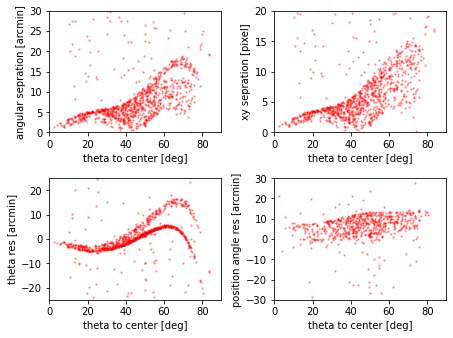

In [12]:
pic.draw_residual(dpi=72, s=2, c = 'red',alpha=0.3)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.986809551792577
        x: [ 3.319e+00  4.313e-01  6.267e+00  1.461e+01 -1.803e-01
             3.000e+03  2.000e+03]
      nit: 21
      jac: [ 1.310e-02 -1.124e-02  1.153e-02  1.943e-02  3.159e-03
             1.990e-02  1.160e-02]
     nfev: 200
     njev: 25
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>


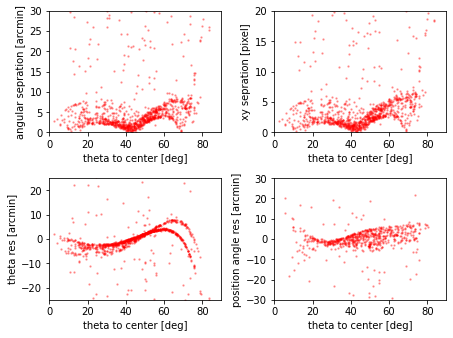

In [13]:
init, result = pic.plate_optimize()
print(result)
x = result.x
pic.az = x[0]
pic.alt = x [1]
pic.az_roll = x[2]
pic.f = x[3]
pic.k = x[4]
pic.c_x = x[5]
pic.c_y = x[6]
pic.draw_residual(dpi=72, s=2, c = 'red',alpha=0.3)


In [14]:
init, result = pic.distortion_optimize(distortion_paras_range=1)
pic.distortion_paras = result.x
result

c:\Users\mlang\constellation_lines\utils_az.py:136: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(r*k/f)/k


ValueError: Catalog coordinates cannot contain NaN entries.

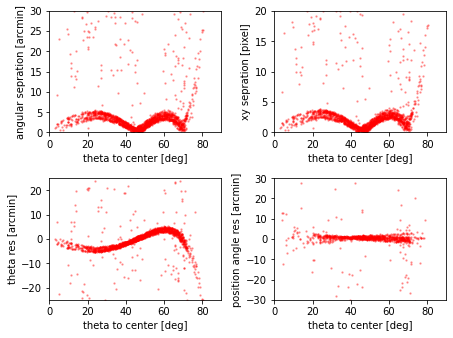

In [ ]:

pic.draw_residual(dpi=72, s=2, c = 'red',alpha=0.3)

In [ ]:
img =  Image.open(file+'.jpg')
sep = angular_separation(pic.az*u.rad,pic.alt*u.rad,pic.catalog_skycoords.az,pic.catalog_skycoords.alt)
sep_constarit= sep<0.45*np.pi*u.rad
selected_cata_skyc = pic.catalog_skycoords[sep_constarit]
cata_x,cata_y,_,_ = pic.az_to_delta_xy(c_az=pic.az*u.rad, c_alt=pic.alt*u.rad, az=selected_cata_skyc.az, alt=selected_cata_skyc.alt, f=pic.f, k=pic.k, ks= pic.ks)

cata_xy = pic.delta_xy_to_xy(cata_x,cata_y,pic.c_x,pic.c_y, pic.az_roll)

%matplotlib qt
fig,ax = plt.subplots(1,1)
ax.imshow(img)
plt.tight_layout()
cata = CircularAperture(np.transpose(cata_xy), r=3)
cata.plot(color='red', lw=1)
plt.title('final')
plt.show()